 # Advanced Machine Learning - programming assignment 2

*Due: Friday December 12th 23:59*

**Please fill in:**
* MARC AVILA PEDEMONTE (9780637)
* name 2 (student id 2)

### Further instructions:
* Code quality is considered during the assessment (of ass 2 & 4). Make sure your code is properly commented. 
* Submit your code in BrightSpace only for ass 2 & 4.
* When you submit the code, make sure to name the submitted file according to your and your collaborators last name (i.e. submitter_collaborator.ipynb).
* Please notice that the grader most likely won't install additional packages. Try to stick with the standard library and the packages listed. 
* **Failure to follow these instructions can affect the assignment grade.**

 ## Reinforcement learning with function approximation

In this assignment, you'll design your own agent to complete an episodic MDP task following the gymnasium framework. The agent will be looking at a small part of the UU logo, and have to decide which of the four compass directions (i.e. left, right, up, down) to move in. The learning task is to find the goal in the center as soon as possible.

The learning objectives of this assignment are:
- Implement two versions of the agent using Semi-gradient SARSA and Q-Learning algorithms with a linear approximation function,
- Implement one agent using DQN algorithm (one deep RL method),
- Demonstrate the difference between on-policy and off-policy RL methods,
- Learn to integrate the approximation function with Tabular RL methods,
- Play with the important parameters, e.g. discount factor $\gamma$, stepsize $\alpha$ and update frequency in DQN; and understand their influence on the learning procedure.  


### 1. Let's start with setting up the enviroment.

The following code defines various aspects of the environment.

In [2]:
import itertools as it
from abc import ABC, abstractmethod
from collections import deque
from enum import IntEnum
import random
from typing import List, Tuple

import numpy as np
import pandas as pd
from scipy import stats


import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium
from gymnasium import spaces

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from matplotlib.patches import Patch

from IPython import display
from IPython.display import HTML
from tqdm import tqdm

In [3]:
# %matplotlib inline
# Constants defining the environment
GOAL = (140, 120)
CENTER = (132, 132)
AVG_MOVEMENT_SIZE = 24
ACCEPTABLE_DISTANCE_TO_GOAL = (AVG_MOVEMENT_SIZE // 2) + 1
RADIUS = 72
WINDOW_SIZE = 28
TIME_LIMIT = 200
TIMEOUT_REWARD = -100.0
MOVE_REWARD = -1
INVALID_MOVE_REWARD = -5


# This is for type inference
State = Tuple[int, int]   
## claro los estados aqui son las coordenadas (x,y) del espacio donde esta el agente


# Action space
class Actions(IntEnum):  
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3
## claro los posibles movimientos son moverte arriba 0, derecha 1, abajo 2, izquierda 3 (reloj)


# Boundaries
class Boundary(IntEnum):  
    WEST = CENTER[0] - RADIUS
    EAST = CENTER[0] + RADIUS
    NORTH = CENTER[1] - RADIUS
    SOUTH = CENTER[1] + RADIUS
## claro las fronteras son estas porque representa que el punto (0,0) esta esquina arriba izquierda
    
    
# Augmented boundarie, not used in this assignment
class AugmentedArea(IntEnum):  
    WEST = Boundary.WEST - (WINDOW_SIZE // 2)
    EAST = Boundary.EAST + (WINDOW_SIZE // 2)
    NORTH = Boundary.NORTH - (WINDOW_SIZE // 2)
    SOUTH = Boundary.SOUTH + (WINDOW_SIZE // 2)
## es porque el punto tiene como un "tamaño de la ventana" al rededor de su posicion, entonces para que no se recorte su imagen
## pues se esta "ampliando aun mas los bordes" 


# Image
ORIGINAL_IMAGE = plt.imread("UU_LOGO.png")
# Convert to one color channel (using only the red channel), with white background
IMAGE = ORIGINAL_IMAGE[:, :, 0] * ORIGINAL_IMAGE[:, :, 3] + (1.0 - ORIGINAL_IMAGE[:, :, 3])


# Get a "camera view" at the position indicated by state
# Use reshape=True to format the output as a data point for the neural network
def get_window(state: State, reshape=False) -> np.ndarray:
    # When indexing the image as an array, switch the coordinates: im[state[1], state[0]]
    window = IMAGE[(state[1] - 14):(state[1] + 14), (state[0] - 14):(state[0] + 14)]
    if reshape:
        return np.reshape(window, (1, 28, 28, 1))
    return window


# Is the state close enough to the goal to be considered a success?
# There is a margin for error, so that the agent can't jump over the goal
def is_goal_reached(state: State) -> bool:
    return np.amax(np.abs(np.asarray(state) - np.asarray(GOAL))) <= ACCEPTABLE_DISTANCE_TO_GOAL


# This is a helper function to render a run
def updatefig(j, images, imgplot, text_act_plot, text_reward_plot):
    # set the data in the axesimage object
    img, time_point, from_state, to_state, act, current_reward = images[min(len(images), j)]
    imgplot.set_data(img)
    text_act_plot.set_text(f"Time step: {time_point} - Action: {act}\nState: {from_state} -> {to_state}")
    text_reward_plot.set_text(f"Current total reward: {current_reward}")
    # return the artists set
    return [imgplot, text_act_plot]
## esto es solo para visualizar como se mueve el agente


# This will render a run of a full epoch
# The function needs a list of tuples containing an image array, a State, the performed action
def render_epoch(animation_data: List[Tuple[np.ndarray, State, Actions]], interval=100, blit=True, **kwargs):
    if not len(animation_data):
        return f"No images in the list"
    fig, ax = plt.subplots()
    imgplot = ax.imshow(np.zeros_like(animation_data[0][0]))
    text_act_plot = ax.set_title("", color="red", fontweight="extra bold", loc="left")
    text_reward_plot = ax.text(5, 255, "", color="red", fontweight="extra bold")
    params = [animation_data, imgplot, text_act_plot, text_reward_plot]
    ani = FuncAnimation(fig,
                        updatefig,
                        fargs=params,
                        frames=len(animation_data),
                        interval=interval,
                        blit=blit,
                        **kwargs)
    animation = HTML(ani.to_jshtml())
    plt.close()
    return display.display(animation)

# This function can be used to smooth obtained plots
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    return np.convolve(y, box, mode='valid')

 The following 2 images show:
 * The original image, with a red dot marking the goal and a red rectangle marking the area where the center of agent must remain. A movement that would take the agent outside this rectangle, places him at the boundary instead. The blue rectangle represents an augmented area that is not necessary in the assignement but with which you can play.
 * What the agent sees if s/he is exactly at the goal.

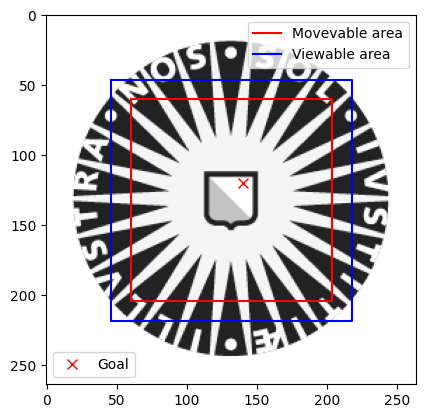

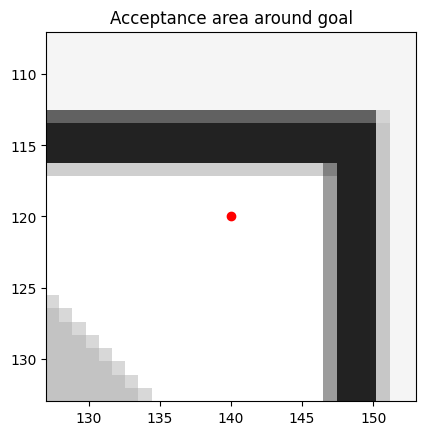

In [4]:
plt.imshow(IMAGE[:, :], cmap='gray', vmin=0, vmax=1.0)
# Plotting uses reversed y-axis now: larger y values are further down
goal_container = plt.plot(GOAL[0], GOAL[1], 'rx', markersize="7")
legend2 = plt.legend(goal_container, ["Goal"], loc=3)

plt.plot([Boundary.WEST, Boundary.WEST, Boundary.EAST, Boundary.EAST, Boundary.WEST],
         [Boundary.NORTH, Boundary.SOUTH, Boundary.SOUTH, Boundary.NORTH, Boundary.NORTH],
         'r-',
         label="Movevable area")
plt.plot([AugmentedArea.WEST, AugmentedArea.WEST, AugmentedArea.EAST, AugmentedArea.EAST, AugmentedArea.WEST],
         [AugmentedArea.NORTH, AugmentedArea.SOUTH, AugmentedArea.SOUTH, AugmentedArea.NORTH, AugmentedArea.NORTH],
         'b-',
         label="Viewable area")

plt.legend()
plt.gca().add_artist(legend2)
plt.show()

# window around goal
img_container = plt.imshow(get_window(GOAL),
                           cmap='gray',
                           vmin=0,
                           vmax=1.0,
                           extent=(GOAL[0] - ACCEPTABLE_DISTANCE_TO_GOAL, GOAL[0] + ACCEPTABLE_DISTANCE_TO_GOAL,
                                   GOAL[1] + ACCEPTABLE_DISTANCE_TO_GOAL, GOAL[1] - ACCEPTABLE_DISTANCE_TO_GOAL))
plt.plot(GOAL[0], GOAL[1], 'ro', linewidth=1)
plt.title("Acceptance area around goal")
plt.show()



The following class provides the functionality of tile encoding. The implementation can be used to define multiple tilings. The default code uses three tilings. You can play with different number of tilings, but please deliver the results with only one setting with multiple tilings.  


Samples:
[[137.16031608  27.74009164]
 [ 12.5175175   38.51018315]
 [167.73197678 245.28819668]
 [201.97761984 122.89195071]
 [226.89729258 123.72898951]]

Indexes of samples:
[[5, 0], [3, 0], [6, 0]]
[[0, 0], [0, 0], [0, 0]]
[[7, 8], [6, 8], [8, 8]]
[[8, 4], [8, 2], [8, 3]]
[[8, 4], [8, 3], [8, 3]]


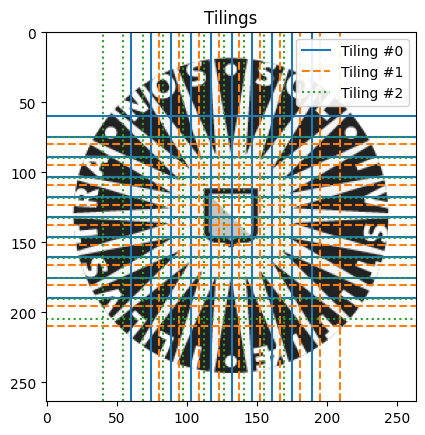

In [5]:
class grid_tilings():
    def __init__(self, number_of_grids = 1, offsets = np.array([[0.0, 0.0]]), bins_per_dim = (9, 9)) -> None:
        # Low value for each dimension, for each grid / tile
        lows = np.array([[Boundary.NORTH, Boundary.WEST]]*number_of_grids)
        # High value for each dimension, for each grid / tile
        highs = np.array([[Boundary.SOUTH, Boundary.EAST]]*number_of_grids)
        # Number of discrete bin for each each dimension, for each grid / tile
        bins = np.array([bins_per_dim] * number_of_grids)
        # The offset is used to setup the overlap of grids
        # offsets = np.array([[0.0, 0.0]]) is one grid starting from lows to highs 
        # offsets = np.array([[20.0, 20.0]]) is one grid starting from lows+[20.0, 20.0] to highs+[20.0, 20.0]

        self.grids = []

        for l, h, b, o in zip(lows, highs, bins, offsets):
            grid = {}
            grid['size']  = b
            grid['low'] = l
            grid['offset'] = o
            grid['points'] = []
            grid['step'] = []
            for dim in range(len(b)):
                points, step = np.linspace(l[dim], h[dim], b[dim]+1, endpoint=False, retstep=True)
                points += o[dim]
                grid['points'].append(points)
                grid['step'].append(step)

            grid['step'] = np.array(grid['step'])
            grid['weights'] = np.zeros(grid['size'])
            self.grids.append(grid)

    # Get the sum of the weights for given continuous coordinates
    def get_weight(self, sample):
        encoded_sample = self.tile_encode(sample)
        w = 0.0
        for grid, (x,y) in zip(self.grids, encoded_sample):
            w += grid['weights'][x,y]
            ##claro, es sumar los pesos que se corresponden con la celda de cada grid que esta activa 
            ##("como que lo que nos han retornado es el xiyi de la grid i que representa la celda xiyi de la grid que esta 
            ## activa (con un 1, todas las demas celdas tienen 0 y al hacer producto escalar con w pues solo se suman esos 
            ## wiwi de la matriz de w's para cada distinta grid i)") 
        return w
    
    
    # Set the weights for given continuous coordinates
    def set_weight(self, sample, target):
        encoded_sample = self.tile_encode(sample)
        for grid, (x,y) in zip(self.grids, encoded_sample):
            grid['weights'][x,y] = target/len(self.grids) # claro porque cada sitio tiene un peso, pero lo repartimos por igual entre todas las grids, porque todas las grids tienen una celda que solapa en ese espacio!!! y cuando estamos en un estado, sacamos su valor (su peso) como la suma de todas las contriuciones del peso de cada grid en la celda de cada grid que cubre ese espacio!
    ## claro esto es simplemeente la forma que necesitamos para todos los algoritmos, de empezar con unos valores de los pesos
    ## w's para cada "estado". Para cada estado, su peso w(state), pues vale igual para todos las celdas de cada grid
    ## que cubran ese estado, y se pone de inicio pues el valor del target final, repartido por igual por todas las celdas
    ## activas de cada tilling. (== para cada tile activo)
    
    ## y tmbien es lo que se usa para actualizar los valores de cada estado (lo que es lo mismo que actualizar los pesos 
    ## que se ven afectado cuando representamos ese estado en el tilling space), y
    ## y esto es lo que se usa en cada paso de los algoritmos cuando actualizas el valor con el nuevo target value obtenido!!!

    # Return the discrete coordinates from continuous coordinates for all grids
    def tile_encode(self, sample):
        encoded_sample = []
        for grid in self.grids:
            encoded_sample.append(self.discretize(sample, grid))
        return encoded_sample    
    
    # Return the discrete coordinates from continuous coordinates for a given grid
    def discretize(self, sample, grid):
        sample = np.array(sample) - (grid['low'] + grid['offset'])
        sample = np.maximum(sample, np.array([0]*len(grid['size'])))
        index = sample // grid['step']
        index = np.minimum(index, grid['size']-1)
        return list(index.astype(int))

    # Plot the different grids
    def visualize_tilings(self):
        """Plot each tiling as a grid."""
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        linestyles = ['-', '--', ':']
        legend_lines = []
        
        for i, grid in enumerate(self.grids):
            for x in grid['points'][0]:
                l = plt.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
            for y in grid['points'][1]:
                l = plt.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
            legend_lines.append(l)
        plt.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
        plt.title("Tilings")


# default setting for 3 tilings:
offsets = np.array([[0.0, 0.0], [20.0, 20.0], [-20.0, 15.0]])
tilings = grid_tilings(3, offsets)

# example for one tiling
# tilings = grid_tilings()

plt.imshow(IMAGE[:, :], cmap='gray', vmin=0, vmax=1.0)
tilings.visualize_tilings()

# Test with some sample values
samples = np.random.rand(5, 2) * 264
## Claro aqui ha generado 5 puntos (x,y) en el espacio continuo, es decir que pueden tomar valores de 0 a 264 cada coordenada
## y los ha generado con funcion random uniforme(0,1) multiplicando por 264, asi son uniformemente random entre 0 a 264! claro
print("\nSamples:", samples, sep="\n")
encoded_samples = [tilings.tile_encode(sample) for sample in samples]
## Y entonces, hace el test de aplicar las funcionalidades de la clase que hemos creado!
## Hemos creado un objeto de la clase tillings que es de 3 grids con las caracteristicas default (hecho arriba justo)
## Y entonces probamos de usar con este objeto, su funcionalidad tile_encoding, para convertir las coordenadas continuas
# de 5 estados en el espacio, a coordenadas discretas representadas como las celdas de cada uno de los 3 grids (tillings)
## que usamos! Y claro, pues para cada estado (tenemos 5 estados), pues tenemos 3 celdas xy discretas que ocupa de cada uno
## de los grids!!
## Recordemos que los grids cubren todo el espacio por si solos cada uno! Y cada punto continuo en nuestro espacio, siempre
## cae dentro de todos los grids que tengamos! Por lo tanto siempre tenemos una única celda activa para cada grid!
print("\nIndexes of samples:", *[s for s in encoded_samples], sep="\n")

 The following functions complete the definition of the environment. The agent's movements always go in the intended direction, but the distance travelled has a small random component. Besides by reaching the goal, the episode also terminates after TIME_LIMIT (200) steps; at that point, the agent gets a negative reward TIMEOUT_REWARD.

In [6]:
class Environment(gymnasium.Env):
    metadata = {'render.modes': ['human', 'rgba_array']}
    bx = np.array([AugmentedArea.WEST, AugmentedArea.WEST, AugmentedArea.EAST, AugmentedArea.EAST, AugmentedArea.WEST])
    by = np.array([AugmentedArea.NORTH, AugmentedArea.SOUTH, AugmentedArea.SOUTH, AugmentedArea.NORTH, AugmentedArea.NORTH])

    def __init__(self):
        self.num_actions = Actions
        self.action_space = spaces.Discrete(len(self.num_actions))
        self.observation_space = spaces.Discrete(1)
        self.display = None
        self.img, self.img_container = Environment._init_visual_area(IMAGE)
        self.time = 0

    def seed(self, seed=None) -> int:
        np.random.seed(seed)
        return seed

    def step(self, action: Actions):
        assert self.action_space.contains(action)
        (x, y), was_invalid = self._validate_state(self._move(self.state, action))

        self.state = (x, y)
        reward = MOVE_REWARD if not was_invalid else INVALID_MOVE_REWARD
        reward = TIMEOUT_REWARD if self.time >= TIME_LIMIT else reward
        reward = self.time * reward 
        done = is_goal_reached(self.state) or self.time >= TIME_LIMIT
        self.time += 1
        return self.state, reward, done, {}

    ## esta funcion cuando la aplicas, te devuelve en el estado del environment que quieras para empezar de nuevo,
    ## o si no le especificas ningun estado en concreto, te devuelve a un estado random del environment para empezar de nuevo
    def reset(self, state: State = None) -> State:
        self.state = self.starting_state() if not state else state
        self.time = 0
        return self.state

    # returns the current environment situation
    def render(self, mode='rgba_array'):
        curr_img = np.array(self.img_container.get_array())
        x, y = self.state
        scaler = 4
        w, e, n, s = x - scaler, x + scaler, y - scaler, y + scaler
        curr_img[n:s, w:e, 0] = 255
        curr_img[n:s, w:e, 1] = 0
        curr_img[n:s, w:e, 2] = 255
        curr_img[n:s, w:e, 3] = 255
        cropped_img = curr_img  # Just for debugging purposes
        if mode == 'rgba_array':
            plt.close()
            return cropped_img  # return RGB frame suitable for video
        elif mode == 'human':
            container = plt.imshow(curr_img)
            ax = container.axes
            ax.set_xlim(Boundary.WEST, Boundary.EAST, auto=None)
            ax.set_ylim(Boundary.SOUTH, Boundary.NORTH, auto=None)
            return container
        else:
            raise Exception(f"Please specify either 'rgba_array' or 'human' as mode parameter!")
    ## a esta funcion le puedes pasar argumento mode='human' si quieres visualizarlo con la vista del punto y su entorno
    ## y si no le pasas nada, pues te lo va a mostrar con la vista generica de todo el espacio y donde esta el agente
            
            
    # Return a randomly chosen non-terminal state as starting state
    def starting_state(self) -> State:
        while True:
            state = (
                np.random.randint(Boundary.WEST, Boundary.EAST + 1),
                np.random.randint(Boundary.NORTH, Boundary.SOUTH + 1),
            )
            if not is_goal_reached(state):
                return state
        ## eso es, genera estado random y te lo devuelve, siempre y cuando el estado random que ha generado no haya sido
        ## justamente el terminal state (ya seria mucha mala pata en verdad)

    ## metodo que te cambia el estado segun la accion que hayas elegido (recordar 0 ir norte, 1 ir este, 2 ir sud y 3 ir oeste)
    ## y ademas de la accion, le añade un componente random para que te puedas pasar un poco mas o menos (no largada fija del paso)
    ## y devuelve el estado al que te mueves, con el cual con la funcion step podras obtener la recompensa que te da esta accion!
    ## todas estas funcionalidades del environment habra que hacerlas servir cuando hagas la funcion que te simula un episodio
    @staticmethod
    def _move(state: State, action: Actions) -> State:
        x, y = state
        if action == Actions.NORTH:
            y -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.SOUTH:
            y += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.WEST:
            x -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        elif action == Actions.EAST:
            x += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        return x, y

    ## funcion que te valida que el estado al que te has movido, sea valido o no. Habra que aplicarla siempre tambien
    ## en las simulaciones de un episodio, ya que cuando tu hagas un move, tendras un nuevo state, le aplicas esta funcion
    ## para validar o no, y con el output podras aplicar el step y te dira la recompensa segun lo obtenido (distinta recompensa si te pasas de frontera...)
    @staticmethod
    def _validate_state(state: State) -> Tuple[State, bool]:
        x, y = state
        is_invalid = False
        if y < Boundary.NORTH:
            is_invalid = True
            y = int(Boundary.NORTH)
        if y > Boundary.SOUTH:
            is_invalid = True
            y = int(Boundary.SOUTH)
        if x < Boundary.WEST:
            is_invalid = True
            x = int(Boundary.WEST)
        if x > Boundary.EAST:
            is_invalid = True
            x = int(Boundary.EAST)
        return (x, y), is_invalid

    @staticmethod
    def _init_visual_area(img) -> np.ndarray:
        x, y = img.shape
        my_dpi = 80
        fig = Figure(figsize=(y / my_dpi, x / my_dpi), dpi=my_dpi)
        canvas = FigureCanvasAgg(fig)
        ax = fig.gca()

        ax.plot(GOAL[0], GOAL[1], 'ro', linewidth=5)
        ax.plot(Environment.bx, Environment.by, 'b-')
        img_container = ax.imshow(img[:, :], cmap='gray', vmin=0, vmax=1.0)
        ax.axis('off')
        fig.tight_layout()
        canvas.draw()  # draw the canvas, cache the renderer
        s, (width, height) = canvas.print_to_buffer()
        image = np.frombuffer(s, np.uint8).reshape((height, width, 4))
        img_container.set_data(image)
        plt.close()
        return image, img_container



### 2. Implement your agent for Semi-gradient SARSA and Q-Learning

Next comes your part. We start with integrating the linear approximation function with Tabular RL methods. 

**2.1** The following class is responsible for the agent's behavior. The select_action function should implement the epsilon-greedy policy, and return an action chosen according to that policy. **Please fill in the missing codes in select_action function (1.5 points).** 

 Remark: This is an abstract class.
 Hence, its sole purpose is creating subclasses from it, which is also the reason it cannot be instantiated.
 The following subsequent subclasses will provide a specific implementation for the methods that are missing here.
 Therefore, you can ignore the functions that are not implemented. This is just a common way to make sure that all subclasses behave similarly.

In [7]:
class Agent(ABC):
    def __init__(self, alpha: float, gamma: float, epsilon: float):
        # set up the value of epsilon
        self.alpha = alpha  # learning rate or step size
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.hist = []

    # Choose action at state based on epsilon-greedy policy and valueFunction
    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = True) -> int:

        # TO BE FILLED (1.5 points) ------------------------------------------------------------------------------
        
        # First it has to be assumed that a list with the q-values for each (state-action) pair will be provided (if not one can not implement epsilon greedy decision making)
        # But using Function Approximation, and taking a look at the methods that the real agents (watching the codes below) provide
        # what will be provided is a list of all the values for one particular state, and all their possible actions
        # this would be a function of state and action that returns a value depending on the input state and input action,
        # and the state has already been selected so the remaining thing to consider is the action
        values = self.values(state) # this function values(state) returns a vector of a single row (state determined)
                                      # and as many columns as possible actions exist, with their q-values for that state
        
        # List with all the possible actions
        actions = [0,1,2,3] # same as defining actions = np.arange(len(values))    

        
        # Using or not the greedy strategy depending on the input variable of the function
        if use_greedy_strategy == True:
            # Searching the maximum q-value of the values for this state
            max_q_value = max(values)
            
            # Only considering the action (or multiple if they draw)
            best_actions = [action for action, q in enumerate(values) if q == max_q_value]
        
        
        # Using the epsilon greedy strategy:
        elif use_greedy_strategy == False:
        
            # Generate a random uniform number to decide if greedy action or random action is selected in this step (run = call of this agent)
            u = np.random.uniform(0,1)

            # Greedy action: select with probab (1-eps) the best possible action to take in the situation of being in this particular state
            if u <= (1 - self.epsilon):
                # Searching the maximum q-value of the values for this state
                max_q_value = max(values)
                # Keeping the action that gives the best (higher) q-value in this state
                best_actions = [action for action, q in enumerate(values) if q == max_q_value] # the list only will have the maximal q value actions which will be then 100% sure picked in the return of the function

            # Random action: select with probab (eps) one among all possible actions randomly
            elif u > (1 - self.epsilon):
                best_actions = actions # the function in the return will pick randomly one among all possible

        # ----------------------------------------------------------------------------------------------------------

        self.hist.append(values) # this is for saving the vector with all the q-values depending on action for this particular state
        return int(np.random.choice(best_actions))

    # Return estimated action value of given state and action
    @abstractmethod
    def value(self, state: State, action: Actions) -> float:
        pass

    # Return vector of estimated action values of given state, for each action
    @abstractmethod
    def values(self, state: State) -> np.ndarray:
        pass

    # Set value for given state and action
    @abstractmethod
    def set_value(self, state: State, action: Actions):
        pass
    
    # learn with given state, action and target
    # different between on-policy and off-policy
    @abstractmethod
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False) -> int:
        return None

    # Return estimated state value, based on the estimated action values
    def state_value(self, state):
        return np.max(self.values(state))

    # Plot the state value estimates. Use a larger stride for lower resolution.
    def plot_state_values(self, stride=1):
        self.v = np.zeros(
            ((Boundary.SOUTH - Boundary.NORTH + stride) // stride, (Boundary.EAST - Boundary.WEST + stride) // stride))
        for j, x in enumerate(range(Boundary.WEST, Boundary.EAST + 1, stride)):
            for i, y in enumerate(range(Boundary.NORTH, Boundary.SOUTH + 1, stride)):
                self.v[i, j] = self.state_value((x, y))

        plt.imshow(self.v)
        plt.colorbar()
        return plt.show()

    def plot_q_values(self, skip=1):
        return pd.DataFrame(self.hist[::skip]).plot()



**2.2** The next classes are two agents using either episodic semi-gradient Q-Learning and episodic semi-gradient SARSA algorithm to estimate the value function. Both agents use the same linear function approximation method with tile coding. **Implement the `learn` function according to the update rule for the respective algorithm (1 point for each)**. 
 
 REMARK: Both agents use the same tile coding. This method helps splitting the state-space into discrete chunks. Each chunk is associated with one weight.

In [8]:
# This class handles the function approximation, with several methods to query and update it. 
# A linear approximation function is used, making the computation much faster.
class QAgent(Agent):
    def __init__(self, alpha: float, gamma: float, epsilon: float, num_tilings: int = 3, bins_per_dim: tuple = (9, 9)):
        super().__init__(alpha, gamma, epsilon)
        # Use a tile coding
        self.tilings = [grid_tilings(number_of_grids=num_tilings, bins_per_dim=bins_per_dim) for a in Actions]

    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.tilings[action].get_weight(state)

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return [self.tilings[action].get_weight(state) for action in Actions]
    
    # Set value for given state and action
    def set_value(self, state: State, action: Actions, value: float):
        self.tilings[action].set_weight(state, value)
    
    # learn with given state, action and target
    # different between on-policy and off-policy: for Qlearning, the agent does not need to return the next selected action
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        # TO BE FILLED (1 point)
        raise NotImplementedError


In [9]:
class SARSAAgent(Agent):
    def __init__(self, alpha: float, gamma: float, epsilon: float, num_tilings: int = 3, offsets = np.array([[0.0, 0.0], [20.0, 20.0], [-20.0, 15.0]]), bins_per_dim: tuple = (9, 9)):
        super().__init__(alpha, gamma, epsilon)

        # Use a tile coding
        self.tilings = [grid_tilings(number_of_grids=num_tilings, offsets=offsets, bins_per_dim=bins_per_dim) for a in Actions]

        ## aqui creo que esta creando el sistema de muchas grids, pero haciendo como una dimension mas que seria por todas las posibles acciones!
        ## porque entonces, podras tener, las funcionalidades de las tiles que se pueden aplicar a estados, pero ademas tendras
        ## todo eso guardado para las distintas acciones que se han tomado desde ese estado...
        
        # CLARO! Porque recordemos que en la parte de codigo donde se define la clase "grid_tillings" y todas sus funcionalidades,
        # recordemos que se aplica todo todo todo a nivel de estado! todas las funcionalidades de obtener pesos, tal, representacion de estados...
        # todo se definía a nivel de ESTADO únicamente, alli no hay ninguna variable ACCIÓN.
        # Entonces lo que se puede hacer es aplicar eso, pero duplicarlo (copiarlo) para todas las posibles acciones! Y las
        # actualizaciones de valores por estado, hacerlas solo en la copia de esas grids por estado que se correspondan con esa
        # acción que se ha hecho en ese momento!! Y ASÍ ES COMO SE HACE PARA PODER TENER LOS VALORES POR ESTADO-ACCIÓN
        
    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.tilings[action].get_weight(state)
    ## CLARO: recordar que la función "get_weight" es la que te da el valor de la función q(s,a) sombrero (la function approximation)
    ## que como es lineal, esta funcion ^q no es mas que el producto escalar de el vector de pesos por el vector unitario de representación de estados
    ## que basicamente el vector unitario de representacion de estados, es todo 0's excepto valores 1 en las celdas de cada grid
    ## que estan ocupadas por el agente en ese momento (que cubren el estado actual)
    
    ## recordar que la funcion "get_weight", es sumar los pesos que se corresponden con la celda de cada grid que esta activa 
    ##("recordar que la función tile encode codifica el estado continuo (x,y), como valores xiyi de las distintas grids i que cubren
    ## todo el espacio! Y para hacerlo hace uso de la funcionalidad "discretize" que te da cada xi, cada yi por cada grid i
    ## que tenemos. 
    ## Entonces con esto, el state ya lo tenemos como codificado, que en este caso sería representado como el xiyi de cada grid i
    ## En nuestro caso tenemos 3 grids, asi que cada estado lo tenemos representado como x(s) = [[x1y1], [x2,y2], [x3,y3]]
    ## que serían las celditas (tiles) de cada reja (de cada tilling) que estarían activas (cuyo valor sería 1 dentro de la rejilla viendola como una matriz)
    ## Con lo cual, de la matriz de pesos, cuando se hace el producto escalar por asi decirlo entre matrices de w's y de x's
    ## pues es la suma de w's activas.
    
    ## Y en esta función value, ya estamos pasando como input una determinada accion para poder quedarnos con aquella que 
    ## querrámos ya en particular

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return [self.tilings[action].get_weight(state) for action in Actions]
    ## en cambio esta función, te retorna los valores por todas las distintas acciones posibles, y tu eso lo podrás tratar
    ## para ver cual es la mejor acción! Pero es lo mismo que la función de arriba solo que la de arriba ya te selecciona
    ## el valor para una determinada accion que le pases como input
    
    
    
    # Set value for given state and action
    def set_value(self, state: State, action: Actions, value: float):
        self.tilings[action].set_weight(state, value)
    ## recordar que la funcion set_weight(state, target) actualizaba los pesos que dan el q-value para un estado determinado!
    ## claro esto es simplemeente la forma que necesitamos para todos los algoritmos, de empezar con unos valores de los pesos
    ## w's para cada "estado". Para cada estado, su peso w(state), pues vale igual para todos las celdas de cada grid
    ## que cubran ese estado, y se pone de inicio pues el valor del target final, repartido por igual por todas las celdas
    ## activas de cada tilling. (== para cada tile activo)
    
    ## y tmbien es lo que se usa para actualizar los valores de cada estado (lo que es lo mismo que actualizar los pesos 
    ## que se ven afectado cuando representamos ese estado en el tilling space), y
    ## y esto es lo que se usa en cada paso de los algoritmos cuando actualizas el valor con el nuevo target value obtenido!!!

    
    
    # learn with given state, action and target
    # different between on-policy and off-policy: for SARSA, the agent needs to return the next selected action
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False):
        
        # TO BE FILLED (1 point) -------------------------------------------------------------------------------------------
        
        # This is the function that does the learning procedure using the update rule and all the inputs that are provided
        # the inputs will be present as other functions will be run during a real simulation, so the variables
        # state, action, next state and reward will be provided here as well as the done variable that indicates if the final state has been reached
        # remember the done variable is provided by the environment functionality "step" that checks if the final state is reached or if the time is exceeded
        
        # Most recent q-values q(s,a): function that returns de q-value given the current action and the current state, applying the function that calculates it using the current weights so far and the space state representation
        current_q = self.value(state, action)
        
        
        # Check if the new state is terminal (to compute the weight update using as a "target" in the update rule only the reward)
        if done == True:
            # Target of the SARSA update rule in this case (case we reach the final state and no more "next state q values we have so far" are needed)
            td_target = reward
            
            # General Update Rule formula
            new_q = current_q + (self.alpha)*(td_target - current_q)
            
            # Next action to take (it is what the function needs to return)
            next_action = 0
        
        
        # In case we have not reached the terminal state with our state, action, we keep the normal procedure for updating
        elif done == False:
            # Choose the action for the next state (next action), using the function defined above that uses the epsilon greedy strategy 
            next_action = self.select_action(next_state, use_greedy_strategy = False)
            
            # Search the q-value that we have so far (the most recent q-value we have using our function) for the pair (next state, next action) to be able to compute it in the update rule of the algorithm
            next_q = self.value(next_state, next_action)
            
            # Target of the SARSA update rule
            td_target = reward + (self.gamma * next_q)
            
            # General Update Rule formula
            new_q = current_q + (self.alpha)*(td_target - current_q)
         
        
        # Save the updated q-value with the applied rule to the function (basically updating the weights of the function that cover this space for this particular action, with the new updated q-value)
        self.set_value(state, action, new_q) # there is a function defined that does exactly this
        
        return next_action
        #-------------------------------------------------------------------------------------------------------------------
        
        #raise NotImplementedError


 The following function handles the interaction between agent and environment for a single episode. By passing the same value_function object in multiple calls to this function, the agent can learn from a sequence of such interactions.

 **Please fill in the missing parts (1 point).** 

In [10]:
# env: Environment in which the agent is supposed to run 
# agent: agent to learn
# initital state: Starting state for the environment
# is_learning: should the value function be updated during the simulation?
# is_rendering: should the run be recorded? (Takes some time to compute)


def run_episode(env: Environment,
                agent: Agent,
                initial_state: State,
                is_learning: bool = True,
                is_rendering: bool = False) -> Tuple[State, float]:
    # Initialize reward for episode
    total_reward = 0.0
    # Initialize the policy (if is_greedy=True then the agent follows its optimal policy, otherwise it will randomly select an action)
    is_greedy = not is_learning
    # Get initial action
    current_state = initial_state
    current_action = agent.select_action(initial_state, use_greedy_strategy=is_greedy)

    # Track the rendering
    animation_data = []
    animation_data.append((env.render(), env.time, None, current_state, None, 0))
    # Initialize variables
    next_state = None
    done = False
    next_action = None
    while not done:
        # TO BE FILLED----------------------------------------------------------------------------------------------
        # Apply the step function of the environment that returns this list of things that will be used by the agent recursively
        next_state, reward, done, _ = env.step(current_action)  # step es una self variable del environment, no hay que pasarla como input ya se actualiza ella en la misma funcion step
        #------------------------------------------------------------------------------------------------------------
        
        total_reward += reward
        if is_rendering:
            curr_img = env.render()
            animation_data.append((curr_img, env.time, current_state, next_state, current_action, total_reward))
        
        # Execute the learning and update the state and action
        # TO BE FILLED (1 point) ---------------------------------------------------------------------------------
        
        if is_learning == True:
            # Select the next action for the agent based on the environment and current situation, applying the learn function of the agent
            next_action = agent.learn(current_state, current_action, next_state, reward, done)
            # remember that this learn function already has implemented the greedy strategy action selection function, but it does it based on the learning algorithm updating weights and qvalues that keep being updated
        
        elif is_learning == False:
            # Select the next action only by following the greedy policy all time, and not making any update on the w's (so on the q values) and just simulating an episode following the greedy policy with the q-values that the RL Problem has so far
            next_action = agent.select_action(next_state, use_greedy_strategy = is_greedy) 
            
        # Update the variables to remake the loop with the new step conditions obtained
        current_state = next_state
        current_action = next_action
        
        # --------------------------------------------------------------------------------------------------------
        
    agent.last_action = None
    return current_state, total_reward, animation_data


 To help understand your agent, you can render the agent's performance by setting render to True and running the `run_epoch` function. 
 
 There are some helper functions. They might help you implement the agent correctly. 
 * `agent.plot_state_values` shows you how the agent values different states
 * `agent.plot_q_values` shows the q_values that the agent had over the course of his life time. (That could be a lot. There's a skip parameter to reduce the amount of data points)

 REMARK: Keep in mind, the following is just one example run. Don't expect the model to be fully trained after just one episode. The training part follows in the next section.

(84, 104)
(128, 107)


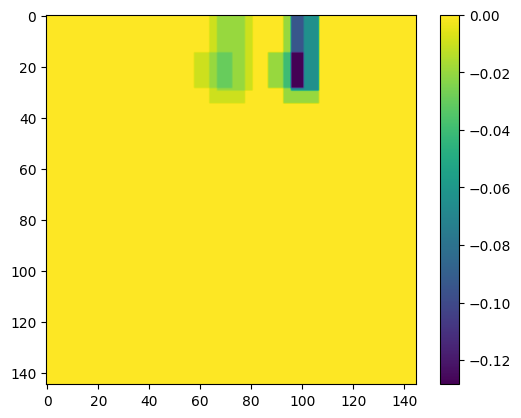

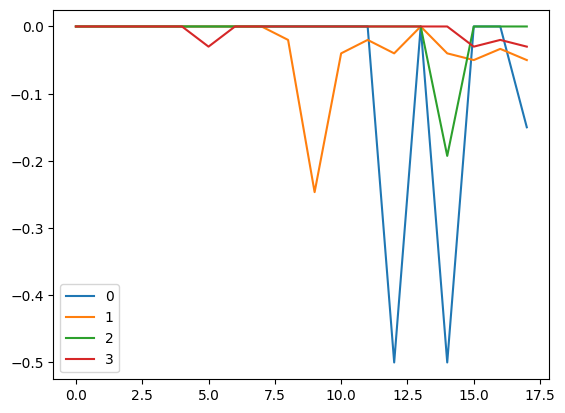

In [11]:
env = Environment()
epsilon = 0.0
gamma = .7
alpha = 1e-2
# agent = QAgent(alpha, gamma, epsilon)
agent = SARSAAgent(alpha, gamma, epsilon)
start_state = env.reset()
print(start_state)
end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning=True, is_rendering=True)
print(end_state)
agent.plot_state_values()
agent.plot_q_values(skip=1)
render_epoch(animation_data, interval=100)


## The first plot shows the value of the highest q(s,a) for all states, taking the action that has the highest q value for that state.
## as it has just started learning (only one episode has been ran) almost all the values are negative or zero

## The second plot shows the steps of the episode and the action and change of states produced by the agent, as well as the reward accumulated so far

## The third plot shows the q(s,a) values throughout the simulation, this is, for each step of the epoisode, the q(s,a)
## of the state that was visited in that time step! And 4 different lines to represent the value of q in that state, for 
## all the possible actions

### 3. Run the simulation, play with parameters and analyse results

 Now it's time to train both algorithms/agents on the environment. 
 
 In the simulations, please plot the measure of each algorithm's performance as a function of the episode (i.e. the sum of all immediate rewards received in each episode). You shall play with a few combinations of two parameters discount factor $\gamma$ and stepsize $\alpha$ (at least two variables for each parameter). During the experiments, keep $\epsilon$ fixed at $0.01$. A reasonable starting point for $\alpha$ is 1e-2. 
 
 REMARK: You can save the parameters and update-to-date Q table of each agent, so that you can still test their performance later. (You can achieve this by keeping the object.)
 

**3.1 Please submit your code as well as the plots presenting compariable performance of the different combinations of parameters for every algorithms (2 points)**. 

REMARK: For a decent comparison all agents should be plotted on the same axis bounds. Also, the plots may be hard to interpret because of the scales. Feel free to do your own smoothing or use the `smooth` function provided in the beginning.

In [49]:
# Your code here for running the simulation and ploting the sum of immediate reward in each episode.

# Init the environment and run Q-Learning & SARSA

# Save and plot the results

# TO BE FILLED.---------------------------------------------------------------------------------------------------------

# Setting all the possible parameters with which we will run the experiments
gammas = [0.3, 0.7, 0.95]
alphas = [0.1, 0.01, 0.005] 
epsilon = 0.01

n_episodes = 1500

# Setting the environment
env = Environment()

# Dictionary to save the sum of immediate rewards received in each episode
sarsa_rewards = {}

# Dictionary to keep the different Agent objects created with their parameters to be able to test their performance later
tested_agents = {}

# For each possible combination of parameters, we will run a simulation with n_episodes
for gamma in gammas:
    for alpha in alphas:
        # Creating a new Agent with this parameter combination
        agent = SARSAAgent(alpha, gamma, epsilon) # agent = QAgent(alpha, gamma, epsilon)
        # Setting new values for agent... it automatically happens when creating a new one
        
        # Creating a list to save the total rewards per episode of this particular Agent
        episode_rewards= []
        
        # Simulation with this conditions
        for episode in range(n_episodes):
            # Setting an initial starting state for each episode
            start_state = env.reset()
            # Running an episode simulation
            end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning=True, is_rendering=False)
                            # the step funcion of the environment, used during the run_episode already takes into account the time limit or step limit
            # Total reward received for one complete episode
            episode_rewards.append(total_reward)
        
        # Saving the reward received for all the episodes, in the dictionary for each Agent with different parameters
        sarsa_rewards[(gamma, alpha)] = episode_rewards
        
        # Saving each Agent object used
        tested_agents[(gamma, alpha)] = agent
        
        print(f"Simulations ended for Agent SARSA with parameters γ = {gamma} and α = {alpha}. ")
        
# ------------------------------------------------------------------------------------------------------------------------

Simulations ended for Agent SARSA with parameters γ = 0.3 and α = 0.1. 
Simulations ended for Agent SARSA with parameters γ = 0.3 and α = 0.01. 
Simulations ended for Agent SARSA with parameters γ = 0.3 and α = 0.005. 
Simulations ended for Agent SARSA with parameters γ = 0.7 and α = 0.1. 
Simulations ended for Agent SARSA with parameters γ = 0.7 and α = 0.01. 
Simulations ended for Agent SARSA with parameters γ = 0.7 and α = 0.005. 
Simulations ended for Agent SARSA with parameters γ = 0.95 and α = 0.1. 
Simulations ended for Agent SARSA with parameters γ = 0.95 and α = 0.01. 
Simulations ended for Agent SARSA with parameters γ = 0.95 and α = 0.005. 


Put your plots here. (In case your code takes too long to run.) 

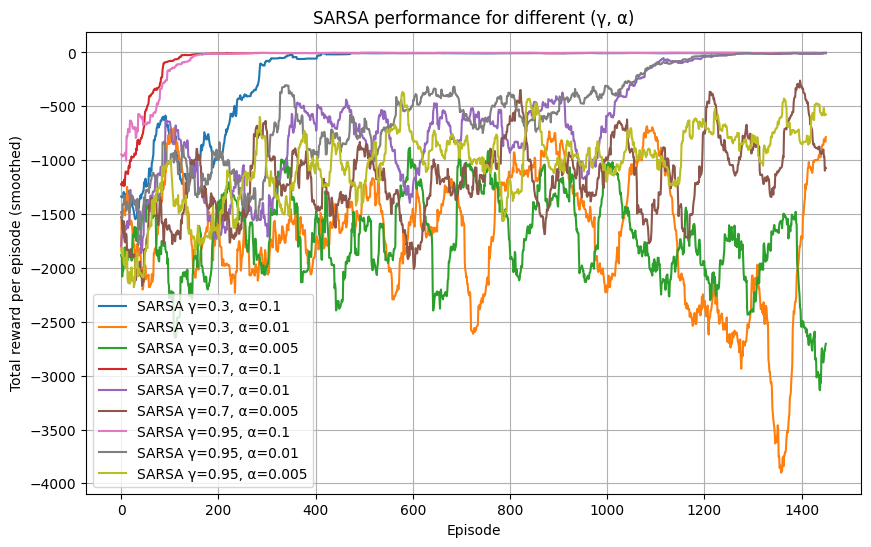

In [50]:
# Making a plot for each combination of the agent parameters we have and the rewards obtained throghout the episodes
plt.figure(figsize = (10,6))

for (gamma, alpha), rewards in sarsa_rewards.items():

    # Curve original
    #plt.plot(rewards, color="gray", alpha=0.2)

    # Curve using the smooth function provided
    box_pts = 50
    smoothed = smooth(rewards, box_pts)
    plt.plot(smoothed, label=f"SARSA γ={gamma}, α={alpha}")
    
# Setting labels to the plot  
plt.xlabel("Episode")
plt.ylabel("Total reward per episode (smoothed)")
#plt.ylim(-4000, 500) # limit to avoid too much range in y axis values (due to the fact that we plot the non-smoothed values)
plt.title("SARSA performance for different (γ, α)")
plt.legend()
plt.grid(True)
plt.show()

**3.2 Please interpret the results/plots (2 points)**. 

Explain what the results say about the parameters alpha (learning rate) and gamma (decay-rate), and their effects on learning.

In [ ]:
# Explanation ------------------------------------------------------------------------------------------------------------

Different **SARSA Agents** have been trained using different parameter combinations for the discount factor  𝛾 ∈ {0.3, 0.7, 0.95} and stepsize  𝛼 ∈ {0.1, 0.01, 0.005}, using a fixed epsilon ε = 0.01 and 1.000 episodes. The plot shows the smoothed total accumulated reward after each episode, for each of the possible parameter combinations. The higher the line is in the graph, the better policy the agent has learned. And the lower and flatter the curve is, it means it has not learn anything.

Observing the plot, one can observe how the learning behaviour of agents changes depending on the combination of the values for the parameters 𝛾 and 𝛼, and looking at the groups of lines that share the same value for one of the two parameters and all the different options tested for the others, can also see how an individual parameter influences the performance.


From the plot is really straightforward to see that the parameter value 𝛼 = 0.1 is the most favorable for learning fast, as with this value, all the different 𝛾 combinations resulted to be the configured agents that learned fastest. These are the lines <font color="red">**Red**</font>, <font color="pink">**Pink**</font> and <font color="blue">**Blue**</font>.

The agents that used 𝛼 = 0.01 where in general the second fastest learners kind of configurated agents. This can be appreciated in lines coloured <font color="grey">**Grey**</font> and <font color="purple">**Purple**</font>. Only exception for that is the <font color="orange">**Orange**</font> line, due to the effect of the low 𝛾 parameter.

Finally, the agents that used 𝛼 = 0.005 resulted in a really slow learning process. These is the case for lines colored <font color="yellow">**Yellow**</font>, <font color="brown">**Brown**</font> and <font color="green">**Green**</font>. 

So in general regarding the 𝛼 values, one can see that with higher values the Agent learns faster in general, and gets results more close to the zero ideal accumulated reward, using less episodes during the training process. When using lower values, the learning process is too slow for this particular environment, as the SARSA Agent is not able to adjust enough the weights of its approximation function to obtain a proper and optimal representation of the value of each state-action pair, resulting in the agent making chaotic trajectories for a long time... However, if one combines a good 𝛾 parameter with a lower 𝛼, which means a high 𝛾 value that allows the agent to look for the future rewards of its actions, the agent can still get to learn an optimal policy over around 1.000 episodes, which is slow but still has the enough time to learn. The worst combination is a low 𝛾 value and low 𝛼 value, that leads the agent to learn really really slow and without any clues....


Observing the plot, one can also see the behaviour of the 𝛾 value in general by itself. 

The curves colored <font color="pink">**Pink**</font>, <font color="grey">**Grey**</font> and <font color="yellow">**Yellow**</font> show how valuing future rewards of the path (high 𝛾 values), helps in learning to approach the goal of the task. In general, this three curves tend to be on top of the others during all the episode simulations, compared to the others (taking into account tha relativeness due to the 𝛼 values, that influences the speed with which they finish the learning process), which means that in general the accumulated reward on their episodes is lower and closer to zero, showing a better performance in general.


Without considering the case of the <font color="red">**Red**</font> and <font color="blue">**Blue**</font> lines, which use 𝛾 values of 0.7 and 0.3 but a high 𝛼 value of 0.1, showing that these parameters values combinations are optimal and lead to a good learning and performance, the other curves that use lower 𝛾 values allow to draw conclusions about their influence in performance: When using a low 𝛾 and focusing only on the inmediate rewards (can not see the final goal), the Agent tends to fail in the learning process, specially if they use a low 𝛼 value that makes the learning process really slow, preventing the approximation function to correctly capture the adequate valuations of state-action pairs, also causing the line of accumulated rewards across different episode to be very noisy with lots of ups and downs, as seen in the <font color="brown">**Brown**</font>, <font color="green">**Green**</font>, <font color="orange">**Orange**</font> and <font color="yellow">**Yellow**</font> lines, with this last one being the least worse one due to a high 𝛾 value of 0.95.


Overall, combinating a **𝛾 value of 0.95 or 0.7 with a 𝛼 of 0.1** seems to be the **best parameters setting for the SARSA Agent** to reach a good performance, balancing between speed of learning, and stability in the accumulated rewards per episode.

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------

**3.3 Let us think one step further by looking at the policies you have learned (1.5 points).** 

Please compare the performance of your learned optimal policies using another simulation. In this simulation, you shall have three agents (Qlearning_Agent, SARSA_agent and Random_agent), where all three agents always use their learned policy to behave and find the goal in the given map (make sure the agent does NOT learn anymore!). The initial policies of Qlearning_Agent and SARSA_agent are the optimal policies learned from the above experiments (based on the final estimated Q-values using Q-Learning and SARSA algorithm respectively). The inital policy of Random_Agent will select 4 actions randomly. 

Describe the performance of three agents by running each agent on the task and discuss the results (1.5 points). You can use the render function provided above (and other helper functions) observe the different behaviors of three agents. You could also use an appropriate plot to show the different performances. **There is no need to submit your codes for this question.**

Some questions you shall think about and answer (in case there are no differences or no special things, just indicate what you observed):
- How does the learned Q-Learning policy and SARSA policy perform differently? Does it show the difference between on-policy and off-policy methods?
- What kind of strategy did the two RL agents learn similarly? How do they differ from the random policy?

In [ ]:
# Code to compare Agents with the Random Agent ------------------------------------------------------------------------

In [51]:
# Define a Random Agent: similar to the other agents, but now the trivial random case
class RandomAgent(Agent):
    def __init__(self):
        # Call the init method with whatever parameters (they will not be used for anything)
        super().__init__(alpha=0.0, gamma=0.0, epsilon=1.0)

    # Key functionality: return a random action between the possible options {0,1,2,3} without taking anything else into acount
    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = True) -> int:
        action = np.random.choice([0, 1, 2, 3])
        # For compatibility reasons with plot_q_values function, save something in the hist
        self.hist.append([0, 0, 0, 0])
        return int(action)

    # The random agent does not use the value function for anything
    def value(self, state, action):
        return 0.0

    def values(self, state):
        return np.zeros(4)

    def set_value(self, state: State, action: Actions, value: float):
        pass

    # The learn functionality of the random agent will not do anything, it doesnt consider any information for making its actions, so it will just return a new random action
    def learn(self, state: State, action: Actions, next_state: State, reward: float, done: bool = False) -> int:
        return self.select_action(next_state, use_greedy_strategy = True)

In [57]:
# Defining a function that will be used to compare the different agents, simulating episodes with them and saving data
def evaluate_agent(env, agent, n_episodes = 30, render_first = False):
    # List where the acumulated rewards (total reward) per episode will be appended
    rewards = []
    
    # List where the trajectory that the agents follow in one of their episodes will be appended 
    data_animations = None  # guardamos la animación del primer episodio si hace falta
    
    # Loop for all the episodes we want to gather data
    for episode in range(n_episodes):
        # Restarting the initial state in each episode
        start_state = env.reset()
        # Applying the run_episode function
        end_state, total_reward, animation_data = run_episode(env, agent, start_state, is_learning = False, is_rendering = render_first and (episode == 2))
        # Appending the total reward gathered in each episode, to the list
        rewards.append(total_reward)

        # Adding the necessary data to be able to render what happened in one of the episodes (the first one for example)
        if render_first and (episode == 2):
            data_animations = animation_data

    return rewards, data_animations

In [58]:
# Code to compare performance of the learned optimal policies

# Creating a new environment for the evaluation of our learned Agents and comparison of them
eval_env = Environment()

# Choosing the best SARSA Agent trained so far
best_SARSA_gamma = 0.95
best_SARSA_alpha = 0.1
best_sarsa_agent = tested_agents[(best_SARSA_gamma, best_SARSA_alpha)]
print("Using SARSA agent with γ =", best_SARSA_gamma, "and α =", best_SARSA_alpha)

# Random Agent
random_agent = RandomAgent()
print("Using RANDOM agent")

# Evaluation procedure
n_eval_episodes = 50
sarsa_rewards_eval, sarsa_animation = evaluate_agent(eval_env, best_sarsa_agent, n_episodes = n_eval_episodes, render_first = True) # render first true to be able to see the first episode rendering the animation
random_rewards_eval, random_animation = evaluate_agent(eval_env, random_agent, n_episodes = n_eval_episodes, render_first = True)

Using SARSA agent with γ = 0.95 and α = 0.1
Using RANDOM agent


In [59]:
# Render SARSA Agent animation of an episode
render_epoch(sarsa_animation, interval = 100)

# Render Random Agent animation of an episode
render_epoch(random_animation, interval = 100)

In [60]:
# Computing some easy but informative metrics of the overall performance of each Agent
print("SARSA mean reward over eval episodes:", np.mean(sarsa_rewards_eval))
print("Random mean reward over eval episodes:", np.mean(random_rewards_eval))

SARSA mean reward over eval episodes: -5.1
Random mean reward over eval episodes: -5244.7


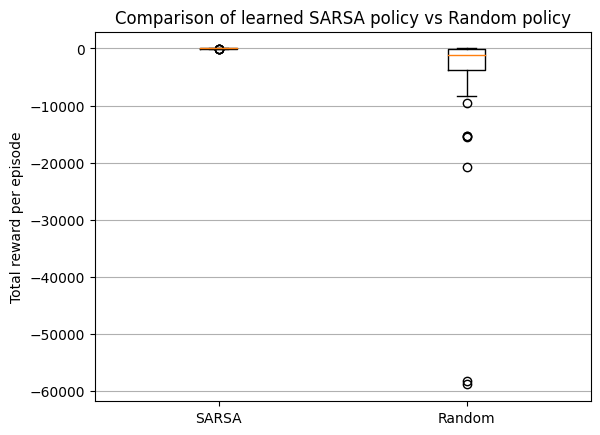

In [61]:
# Box plot to compare the distribution of total rewards per episode that each Agent has obtained during the evaluation episodes
plt.boxplot([sarsa_rewards_eval, random_rewards_eval], labels = ["SARSA", "Random"])
plt.ylabel("Total reward per episode")
plt.title("Comparison of learned SARSA policy vs Random policy")
plt.grid(True, axis = 'y')
plt.show()

In [ ]:
# Comments on the performance comparison of the learned policys and behaviour

Once trained the Agents, we have performed tests trying them in different episodes with different starting conditions, to see how good they perform with the learned q-values and optimal policy using the greedy strategy to advance with the learned values in the previous training process.

On the one hand, selecting the best performing SARSA Agent with 𝛾 = 0.95 and 𝛼 = 0.1, the results in its evaluation are quite good. The animation of an example episode show how, with an aribitrary starting position, the Agent is able to make intelligent steps that approach the goal fast and effectivelly. The average of accumulated negative reward in 30 testing episodes shows how in all of the trials, the overall negative reward is -5.1, which means that regardless of the starting conditions (starting state in the grid), the Agent know how to approach the goal in an efficient and fast way, minimizing the negative reward as much as possible. This is also seen in the box plot, where on average the total reward per episode is low, and has really little variance across different episodes, showing that the agent has really learned something.

On the other hand, the Random agent shows a chaotic trajectory in the example animation of an episode, making random steps and not logical decisions at each time-step of the episode, and ending the episode due to a time limit without reaching the goal. The mean accumulated reward across the different testing episodes also show that the Agent has not learned anything, getting high negative rewards. The box plot shows the cause of that, where by following the random policy, the accumulated rewards that the agent can get are really spread, getting really negative accumulated rewards some times, and low rewards some other few times, just by chance, by following a completely random policy that occasionally can get the Agent reach the goal, but in many other cases, it will not.

In [ ]:
# -----------------------------------------------------------------------------------------------------------------------

### 4. Implement your agent for DQN
---

Now we want to implement an agent for a deep RL algorithm DQN, and compare it with the other two algorithms.

4.1 DQN uses two deep neural networks for training. A policy and a target network. Here we're defining the network architecture. You can just use the network as provided by us. But feel welcome to play around with changing the number of nodes per layers, the activation functions or the layers themselves. However, whether you play with the network or not will not affect your grade.

In [1]:
# Provided DQN Architecture
# PyTorch Q-network skeleton

class QNetwork(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions)
        )
        
    def forward(self, x):
        return self.net(x)


NameError: name 'nn' is not defined

**4.2 Replay Buffer (0.5 points)**

In DQN, we use a replay buffer. The Replay Buffer stores and manages experiences (state, action, reward, next_state, done[has terminated]) so the agent can learn from them multiple times.

You will implement two methods:
  - push method to store an experience in the buffer
  - sample method to return a batch of experiences, i.e., (states, actions, rewards, next_states, dones)

In [ ]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity) ## buffer is a deque with maxlen=capacity, when it is full, it starts kicking out the oldest registers

    # push a transition to the memory (buffer)
    def push(self, state, action, reward, next_state, done):
        # TO BE FILLED.-----------------------------------------------------------------------------
        
        # Creating a tuple with the interaction experience of each time step of an episode
        experienced_transition = (state, action, reward, next_state, done)
        # Appending this experience to the buffer ("database" that will store all the experiences)
        self.buffer.append(experienced_transition)
        # --------------------------------------------------------------------------------------------

        
    # randomly sample a batch of consecutive experiences; please convert to numpy array for later training
    def sample(self, batch_size):
        # TO BE FILLED. ----------------------------------------------------------------------------------------
        
        # Selecting a random number and sample of experiences from the buffer container (without replacement)
        batch = random.sample(self.buffer, batch_size)
        
        # Getting each variable (column of the batch of tuples)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Converting the set of each kind of variables to numpy arrays as indicated
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards) #, dtype = np.float32)
        next_states = np.array(next_states)
        dones = np.array(dones) #, dtype = np.bool_)
        
        return states, actions, rewards, next_states, dones
        # --------------------------------------------------------------------------------------------
        

    def __len__(self):
        return len(self.buffer)

While DQN can learn from continuous features, in our target task, learning from just x and y coordinate makes DQN very data hungry. To decrease the training load, we use a Radial Basis Function to embed the x and y coordinates. A Radial Basis Function transforms a distance to a value between 0 and 1 (with 1 meaning the distance is 0 and 0 meaning the distance is infinity). We use 9 points sampled across the input space as references and transform a position (x,y) into a vector containing 9 values between 0 and 1 by using the Gaussian kernel to transform distances.

In this way, we are enriching the feature and transforming a 2D input into a 9D input with continuous and smooth values. There is no need to implement this function. Please use this function to embed the states before feeding them to DQN. This enables DQN to learn faster with fewer data. 

REMARK: Using a Radial Basis Function to embed the 2D coordinates as a similar approach to using a CNN to embed an image. This will not be covered in the exams!


In [ ]:

# --- Define RBF Hyperparameters ---
N_CENTERS_PER_DIM = 3 # This will create 3x3 = 9 centers
RBF_STATE_DIM = N_CENTERS_PER_DIM * N_CENTERS_PER_DIM # New state_dim = 9

X_RANGE = Boundary.EAST - Boundary.WEST
Y_RANGE = Boundary.NORTH - Boundary.SOUTH

# Create a 3x3 grid of centers
x_centers = np.linspace(Boundary.WEST + X_RANGE/4, Boundary.EAST - X_RANGE/4, N_CENTERS_PER_DIM)
y_centers = np.linspace(Boundary.SOUTH + Y_RANGE/4, Boundary.NORTH - Y_RANGE/4, N_CENTERS_PER_DIM)

# Create a 9x2 array of (x, y) center coordinates
RBF_CENTERS = np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)


# Define the "width" of the gaussian kernels
RBF_SIGMA = (X_RANGE / N_CENTERS_PER_DIM) * 0.5

print(f"Using {RBF_STATE_DIM} RBF features (centers) with sigma={RBF_SIGMA:.2f}")

# --- RBF embedding function ---
def embed_state_rbf(state):
    """
    Calculates the 'closeness' (Gaussian) to each RBF center.
    """
    state_vec = np.array(state, dtype=np.float32) # [x, y]

    # Calculate squared distance from state to centers
    sq_distances = np.sum((state_vec - RBF_CENTERS)**2, axis=1)

    # Apply the Gaussian (bell curve) formula
    # exp(-dist^2 / (2 * sigma^2))
    features = np.exp(-sq_distances / (2 * RBF_SIGMA**2))

    return features.astype(np.float32)

**4.3: DQN** 

Now you are ready to define the DQN agent.
Please implement the following methods (**2 points**):

- select_action
- learn
- run_episode_dqn

Note that you should use the embed_state_rbf() method to embed states.

In [ ]:
class DQNAgent(Agent):
    def __init__(self, state_dim, n_actions, gamma, epsilon_start, epsilon_end, epsilon_decay, learning_rate, buffer_size, batch_size, target_update_freq):
        # Note: We pass learning_rate as 'alpha' and epsilon_start as 'epsilon'
        # state_dim : dimension of the (embedded) input space
        # n_action : number of actions the agent can take
        # gamma: discount factor
        # epsilon_end: we will decrease epsilon over time, epsilon_end is the minimal epsilon value
        # epsilon_decay: how much we will decrease epsilon with each update
        # batch_size: how many consecutive are use for one training update
        # target_update_freq: the frequency with which the target net is updated
        super().__init__(alpha=learning_rate, gamma=gamma, epsilon=epsilon_start)

        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.policy_net = QNetwork(state_dim, n_actions).to(self.device)
        self.target_net = QNetwork(state_dim, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayBuffer(self.buffer_size)

        self.steps_done = 0
        self.episode_rewards = []

    def __del__(self):
        # Clean up CUDA memory if used
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()

    def values(self, state):
        # Gets Q-values for a state that is embedded.
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values_tensor = self.policy_net(state_tensor)
            return q_values_tensor.cpu().numpy().flatten()

    def value(self, state, action):
        # Get Q-value for a specific state-action pair
        q_values = self.values(state)
        return q_values[action]


    def set_value(self, state: State, action: Actions, value: float):
        # This method is for tabular agents, not directly applicable to DQN
        # We can't directly set a weight for a single state-action pair
        pass

    # Choose an action for the given state.
    # Returns the choosen action
    def select_action(self, state, use_greedy_strategy=False):
        # TO BE FILLED. -------------------------------------------------------------------------------------------
        
        # For the pure greedy policy (no exploration) (which will be used when evaluating)
        if use_greedy_strategy == True:
            # Apply the own NN function that obtains the output of the NN which are the q-values for a given state, and all the different action options
            q_values = self.values(state)
            # The selected action in this case is just the one with the highest value for this state
            best_action = int(np.argmax(q_values))
        
        
        # For the epsilon greedy policy (with exploration) (which will be used during training)
        elif use_greedy_strategy == False:
    
            # Generate a random uniform number to decide if greedy action or random action is selected in this step (run = call of this agent)
            u = np.random.uniform(0,1)

            # Greedy action: select with probab (1-eps) the best possible action to take in the situation of being in this particular state
            if u <= (1 - self.epsilon):
                # Apply the own NN function that obtains the output of the NN which are the q-values for a given state, and all the different action options
                q_values = self.values(state)
                # Keeping the action that gives the best (higher) q-value in this state
                best_action = int(np.argmax(q_values))

            # Random action: select with probab (eps) one among all possible actions randomly
            elif u > (1 - self.epsilon):
                best_action = int(np.random.randint(self.n_actions)) # the function in the return will pick randomly one among all possible
            
            
        return best_action
                   
        
        
    # This function takes in a transition and saves it to the memory.
    # Note that you can only learn, if the memory has at least as many saved experiences as the batch size.
    # Think carefully about the roles of the target and the policy network and when to update which
    # You should use torch.nn.MSELoss() to compute the loss, and the optimizer that is part of the agent (self.optimizer)
    def learn(self, state, action, reward, next_state, done):

        # TO BE FILLED.
        
        # Save the transition step to memory (to the memory object of the Buffer class we created applying the push function we defined!)
        self.memory.push(state, action, reward, next_state, done)  # the push method will convert this variables to tuple and append them to the buffer as a new register
        
        # If there are not enough registers for selecting a batch, the training does not occur yet
        if len(self.memory) < self.batch_size:
            # Epsilon decay is made no matter what
            self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)
            return none
        
        
        # If there are enough register to select a batch:
        elif len(self.memory) >= self.batch_size:
            # Sample a batch of experiences, applying the sample functionality of the buffer class we defined before
            states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
            
            # Transform everthing to tensors in the adequate device
            states_t = torch.FloatTensor(states).to(self.device)         # (B, state_dim)
            next_states_t = torch.FloatTensor(next_states).to(self.device)    # (B, state_dim)
            actions_t = torch.LongTensor(actions).unsqueeze(1).to(self.device)  # (B, 1)
            rewards_t = torch.FloatTensor(rewards).to(self.device)        # (B,)
            dones_t = torch.FloatTensor(dones.astype(np.float32)).to(self.device) # (B,)
        
            # 5) Q(s,a) actual (policy_net)
            q_values = self.policy_net(states_t)              # (B, n_actions)
            state_action_values = q_values.gather(1, actions_t).squeeze(1)  # (B,)

            # 6) Q-target: r + gamma * max_a' Q_target(s', a') * (1 - done)
            with torch.no_grad():
                next_q_values = self.target_net(next_states_t)         # (B, n_actions)
                max_next_q_values, _ = next_q_values.max(dim=1)       # (B,)
                target_values = rewards_t + self.gamma * max_next_q_values * (1.0 - dones_t) # to avoid doing this when we are done (dones_t = 1)

            # 7) Calcular pérdida MSE y hacer backprop
            loss_fn = torch.nn.MSELoss()
            loss = loss_fn(state_action_values, target_values)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # 8) Actualizar la red target periódicamente
            self.steps_done += 1
            if self.steps_done % self.target_update_freq == 0: # cada target_upddate_freq number of steps, update the weights into the target network (using a different network to compute the targets, and another networ to compute the function approximation values of each step)
                self.target_net.load_state_dict(self.policy_net.state_dict())    
    
            # Decay epsilon
            self.epsilon = max(self.epsilon_end, self.epsilon - self.epsilon_decay)

        return None


    def state_value(self, state):
        """
        Returns the state-value V(s) = max_a Q(s,a)
        Used by Agent.plot_state_values()
        """
        q = self.values(state)
        return float(np.max(q))

    def plot_state_values(self, stride=1):
        self.v = np.zeros(
            ((Boundary.SOUTH - Boundary.NORTH + stride) // stride, (Boundary.EAST - Boundary.WEST + stride) // stride))
        for j, x in enumerate(range(Boundary.WEST, Boundary.EAST + 1, stride)):
            for i, y in enumerate(range(Boundary.NORTH, Boundary.SOUTH + 1, stride)):
                self.v[i, j] = self.state_value(embed_state_rbf((x, y)))

        plt.imshow(self.v)
        plt.colorbar()
        return plt.show()


In [ ]:
# This method is what you may use to train the agent for one episode. You need to set-up the environment. 
# Until the episode terminates the agent should interact with the environment. 
# is_learning and is_rendering indicate if the agent should also learn (update weights) and if the data for antimating the episode should be collected and returned. 
# In that case make sure to save env.render(), env.time, the previous state, the new state, the choosen action and the total reward for every timestep.

def run_episode_dqn(env, agent, is_learning=True, is_rendering=False):
    state = env.reset()
    state = np.array(state, dtype=np.float32)
    state = embed_state_rbf(state) # embed state
    total_reward = 0.0
    done = False
    animation_data = []

    if is_rendering:
        animation_data.append((env.render(), env.time, None, state, None, 0))

    while not done:
        # TO BE FILLED. --------------------------------------------------------------------------------------------------
        
        # Select an action (during training, we use the epsilon greedy strategy)
        action = agent.select_action(state, use_greedy_strategy = not is_learning)
        
        # Interacition with environment
        next_state, reward, done, _ = env.step(action)
        
        # Converting the states returned by the environment into a valid format to feed the NN
        next_state = np.array(next_state, dtype = np.float32)
        next_state_emb = embed_state_rbf(next_state)
        
        # Accumulating the total reward of the episode at each step
        total_reward = total_reward + reward
        
        # Learning if its the case
        if is_learning == True:
            # Applying the learn function of the Agent
            agent.learn(state, action, reward, next_state_emb, done)
            
        # In case that we want to save the data to render an animation
        if is_rendering == True:
            # Applying the render function of our environment class
            img = env.render()
            # Gathering the animation data of each step
            animation_data.append((img, env.time, state, next_state_emb, action, total_reward))
            
        # Updating the state for the next time-step of the episode
        state = next_state_emb
        
        #-----------------------------------------------------------------------------------------------------------------

    return total_reward, animation_data # Return total_reward

**4.4 Run the simulation, play with parameters and analyse results (1 point)**

Now it's time to train and evaluate DQN algorithm/agent on the environment. 
Similar with the other two algorithms, in the simulations, please plot the measure of DQN's performance. 
You shall play with two parameters: stepsize (learning rate) $\alpha$ and update frequency of target network ($c$ in the slides), and find good values for them. During the experiments, you can stick with the values provided below for the remaining hyperparameters.

There is no need to submit your code for this answer. Please provide the final plots of learning performance for DQN with different parameters.

Tips: When training the DQN agent, you can use a warm-up stage to fill up the memory of this agent with experiences (following the random policy) to speed up the training process. You may also plot the state values to see how the agent learns over time.


In [ ]:
num_episodes_dqn = 4000
gamma_dqn = 0.99
epsilon_start_dqn = 1.0
epsilon_end_dqn = 0.05
epsilon_decay_dqn = (epsilon_start_dqn - epsilon_end_dqn) / (num_episodes_dqn * 0.9) # Decay over 90% of episodes

buffer_size_dqn = 10000
batch_size_dqn = 64

num_seed_dqn = 42

# To be played with, and fill in your final setting, please notice your below results shall follw these two parameters

#----------------------------------------------------------------------------------------------------------------------

learning_rates_dqn      = [1e-3, 5e-4]
target_update_freqs_dqn = [500, 1000]

np.random.seed(num_seed_dqn)
random.seed(num_seed_dqn)
torch.manual_seed(num_seed_dqn)

env = Environment()

dqn_rewards = {}  # para guardar las rewards por episodio para cada combinación

for lr in learning_rates_dqn:
    for tgt_freq in target_update_freqs_dqn:
        print(f"\nTraining DQN with lr={lr}, target_update_freq={tgt_freq}")

        # Crear agente DQN
        agent = DQNAgent(
            state_dim=RBF_STATE_DIM,       # = 9
            n_actions=len(Actions),
            gamma=gamma_dqn,
            epsilon_start=epsilon_start_dqn,
            epsilon_end=epsilon_end_dqn,
            epsilon_decay=epsilon_decay_dqn,
            learning_rate=lr,
            buffer_size=buffer_size_dqn,
            batch_size=batch_size_dqn,
            target_update_freq=tgt_freq
        )

        episode_rewards = []

        # (Opcional) Warm-up: rellenar un poco el buffer con política random
        warmup_episodes = 10
        for _ in range(warmup_episodes):
            run_episode_dqn(env, agent, is_learning=False, is_rendering=False)  # dentro de learn ya mete en memoria si quieres, o metes tú a mano

        # Entrenamiento principal
        for ep in range(num_episodes_dqn):
            total_reward, _ = run_episode_dqn(env, agent, is_learning=True, is_rendering=False)
            episode_rewards.append(total_reward)

            if (ep + 1) % 100 == 0:
                print(f"Episode {ep+1}/{num_episodes_dqn} - mean last 100 reward: {np.mean(episode_rewards[-100:]):.2f}")

        dqn_rewards[(lr, tgt_freq)] = episode_rewards
        
#---------------------------------------------------------------------------------------------------------------------------


In [ ]:
# --------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(10,6))
for (lr, tgt_freq), rewards in dqn_rewards.items():
    smoothed = smooth(rewards, 50)
    label = f"DQN lr={lr}, τ={tgt_freq}"
    plt.plot(smoothed, label=label)

plt.xlabel("Episode")
plt.ylabel("Total reward per episode (smoothed)")
plt.title("DQN performance for different (learning_rate, target_update_freq)")
plt.legend()
plt.grid(True)
plt.show()


# -----------------------------------------------------------------------------------------------------------------------

Please add your final plots here and explain your observations. 

**4.5 Finally, let us compare DQN with Semi-gradient SARSA and Q-learning (1.5 points)**

We require you to train all three algorithms together, compare their learning processes and explain the final learned policies.

**You do not need to submit your code for this question**. Please provide one plot that shows the learning curves of all three algorithms, and then explain your observations. To understand the learned policy, please use the code below to visualize the learned policy for agents, explaining the learned policy and arguing whether it is optimal.

Some questions you shall think about and answer (in case there are no differences or no special things, just indicate what you observed):
- How do the learning procedures of the three algorithms differ?
- What strategy does each RL agent appear to have learned? How is the final learned policy of the three algorithms different (or similar)? - When do we use different algorithms?


Put your plots for the learning procedure and final learned policies here.


Explain your answers. 

Here are the codes you can use to visualize the learned policy. For each possible state, the greedy policy is visualized.


In [ ]:
def plot_agent_policy(agent, stride=1, dqn_agent=True):

    # Plot the agent's policy for each state in the grid.

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Prepare the grid
    x_coords = range(60, 205, stride)
    y_coords = range(60, 205, stride)

    # Create arrays to store actions and colors
    action_grid = np.zeros((len(y_coords), len(x_coords)), dtype=int)
    color_grid = np.empty((len(y_coords), len(x_coords)), dtype=object)

    # Map actions to colors
    action_colors = {
        Actions.NORTH: 'blue',    # NORTH = BLUE
        Actions.SOUTH: 'orange',     # SOUTH = ORANGE
        Actions.EAST: 'green',        # EAST = GREEN
        Actions.WEST: 'purple'       # WEST = PURPLE
    }

    # For each state, get the greedy action
    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            # Embed the state
            if dqn_agent:
                embedded_state = embed_state_rbf((x, y))
            else:
                embedded_state = (x,y)

            # Get greedy action
            action = agent.select_action(embedded_state, use_greedy_strategy=True)

            action_grid[i, j] = action
            color_grid[i, j] = action_colors[action]

    # Create the plot
    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            ax.add_patch(plt.Rectangle((x, y), stride, stride,
                                     facecolor=color_grid[i, j],
                                     edgecolor='gray',
                                     linewidth=0.5))

    # Set plot properties
    ax.set_xlim(60, 204)
    ax.set_ylim(204, 60)
    ax.set_aspect('equal')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Agent Policy Visualization\n(Blue=North, Orange=South, Green=East, Purple=West)')

    # Create legend

    legend_elements = [
        Patch(facecolor='blue', label='NORTH/UP'),
        Patch(facecolor='orange', label='SOUTH/DOWN'),
        Patch(facecolor='green', label='EAST/RIGHT'),
        Patch(facecolor='purple', label='WEST/LEFT')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.show()

plot_agent_policy(agent, stride=1)

In [ ]:
# Ejemplo: elige tus mejores condiciones
best_sarsa_curve = sarsa_rewards[(0.95, 0.1)]           # cámbialo a tus mejores γ, α
best_q_curve     = q_rewards[(0.95, 0.1)]               # lo que tenga tu compi
best_dqn_curve   = dqn_rewards[(1e-3, 500)]             # o los hiperparámetros que mejor te hayan funcionado

plt.figure(figsize=(10,6))

plt.plot(smooth(best_sarsa_curve, 20), label="Semi-gradient SARSA")
plt.plot(smooth(best_q_curve,     20), label="Q-learning")
plt.plot(smooth(best_dqn_curve,   20), label="DQN")

plt.xlabel("Episode")
plt.ylabel("Total reward per episode (smoothed)")
plt.title("Learning curves of SARSA, Q-learning and DQN")
plt.legend()
plt.grid(True)
plt.show()


# plt.plot(smooth(sarsa_rewards,10), label="SARSA")
# plt.plot(smooth(q_learning_rewards,10), label="Q-learning")
# plt.plot(smooth(dqn_rewards,10), label="DQN")

In [ ]:
# plot_agent_policy(agent, stride=1)

plot_agent_policy(best_sarsa_agent, stride=2, dqn_agent=False)
plot_agent_policy(best_q_agent,     stride=2, dqn_agent=False)
plot_agent_policy(best_dqn_agent,   stride=2, dqn_agent=True)


Well done! Before handing in, make sure that the code you hand in work, and that all plots are shown. 

Again, please name this file according to your last names.